# 1- Data Load & Preprocessing 

In [70]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import warnings

In [39]:
# Suppress warnings
warnings.filterwarnings("ignore")

In [40]:
# Load the dataset
file_path = '/kaggle/input/coursera-course-dataset/coursea_data.csv'
data = pd.read_csv(file_path)


In [41]:
data.head()

,Unnamed: 0,course_title,course_organization,course_Certificate_type,course_rating,course_difficulty,course_students_enrolled
0,134,(ISC)² Systems Security Certified Practitioner...,(ISC)²,SPECIALIZATION,4.7,Beginner,5.3k
1,743,A Crash Course in Causality: Inferring Causal...,University of Pennsylvania,COURSE,4.7,Intermediate,17k
2,874,A Crash Course in Data Science,Johns Hopkins University,COURSE,4.5,Mixed,130k
3,413,A Law Student's Toolkit,Yale University,COURSE,4.7,Mixed,91k
4,635,A Life of Happiness and Fulfillment,Indian School of Business,COURSE,4.8,Mixed,320k


In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                891 non-null    int64  
 1   course_title              891 non-null    object 
 2   course_organization       891 non-null    object 
 3   course_Certificate_type   891 non-null    object 
 4   course_rating             891 non-null    float64
 5   course_difficulty         891 non-null    object 
 6   course_students_enrolled  891 non-null    object 
dtypes: float64(1), int64(1), object(5)
memory usage: 48.9+ KB


In [43]:
# 1. Convert `course_students_enrolled` to numeric

def convert_students_enrolled(value):
    value = value.lower()
    if 'k' in value:
        return float(value.replace('k', '')) * 1000
    elif 'm' in value:
        return float(value.replace('m', '')) * 1000000
    return float(value)

try:
    data['course_students_enrolled'] = data['course_students_enrolled'].apply(convert_students_enrolled)
except ValueError as e:
    print("Error in converting 'course_students_enrolled':", e)
    print("Ensure all values are formatted correctly (e.g., '1k', '1.5M').")
    raise


In [44]:
# 2. Handle missing values
# Fill missing ratings with the mean rating
data['course_rating'] = data['course_rating'].fillna(data['course_rating'].mean())

# Fill missing difficulty levels with the most common value
data['course_difficulty'] = data['course_difficulty'].fillna(data['course_difficulty'].mode()[0])



In [45]:
# 3. Normalize the ratings and enrollment numbers for consistent scaling
data['normalized_rating'] = (data['course_rating'] - data['course_rating'].min()) / (data['course_rating'].max() - data['course_rating'].min())
data['normalized_students'] = (data['course_students_enrolled'] - data['course_students_enrolled'].min()) / (data['course_students_enrolled'].max() - data['course_students_enrolled'].min())


In [46]:
# Save the preprocessed data for visualization or further processing
data.to_csv('/kaggle/working/preprocessed_courses.csv', index=False)


In [47]:
# Load the dataset
file_path = '/kaggle/working/preprocessed_courses.csv'
data_new = pd.read_csv(file_path)

In [48]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                891 non-null    int64  
 1   course_title              891 non-null    object 
 2   course_organization       891 non-null    object 
 3   course_Certificate_type   891 non-null    object 
 4   course_rating             891 non-null    float64
 5   course_difficulty         891 non-null    object 
 6   course_students_enrolled  891 non-null    float64
 7   normalized_rating         891 non-null    float64
 8   normalized_students       891 non-null    float64
dtypes: float64(4), int64(1), object(4)
memory usage: 62.8+ KB


Generating preprocessing visualizations...


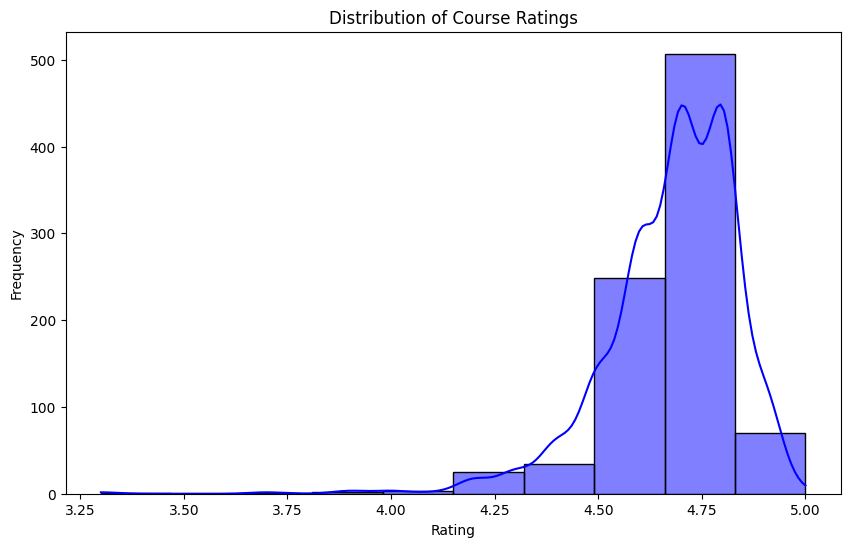

In [49]:
# Visualization after preprocessing
print("Generating preprocessing visualizations...")
plt.figure(figsize=(10, 6))
sns.histplot(data['course_rating'], bins=10, kde=True, color='blue')
plt.title('Distribution of Course Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

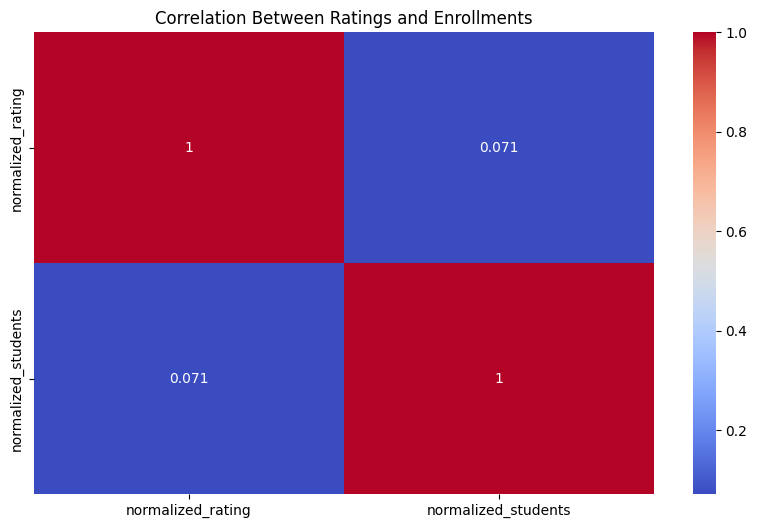

In [50]:
plt.figure(figsize=(10, 6))
sns.heatmap(data[['normalized_rating', 'normalized_students']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Ratings and Enrollments')
plt.show()

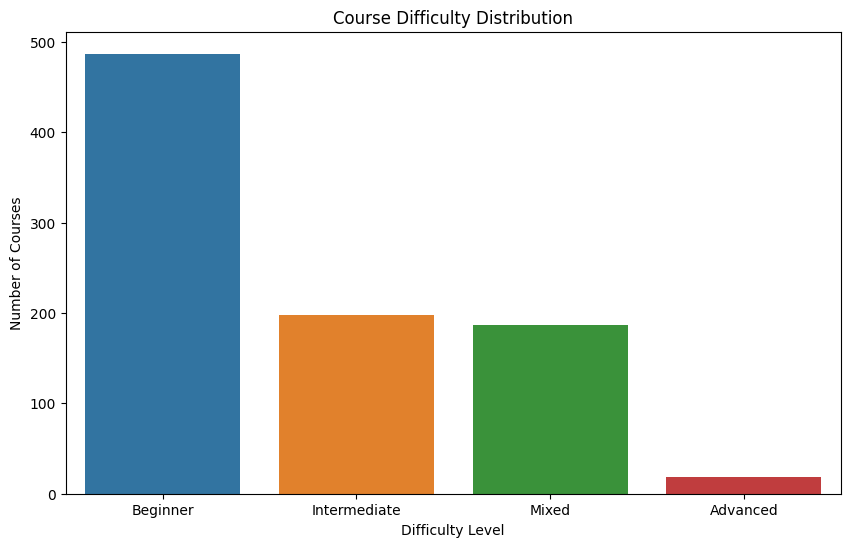

In [51]:
plt.figure(figsize=(10, 6))
sns.barplot(x=data['course_difficulty'].value_counts().index, y=data['course_difficulty'].value_counts().values)
plt.title('Course Difficulty Distribution')
plt.xlabel('Difficulty Level')
plt.ylabel('Number of Courses')
plt.show()

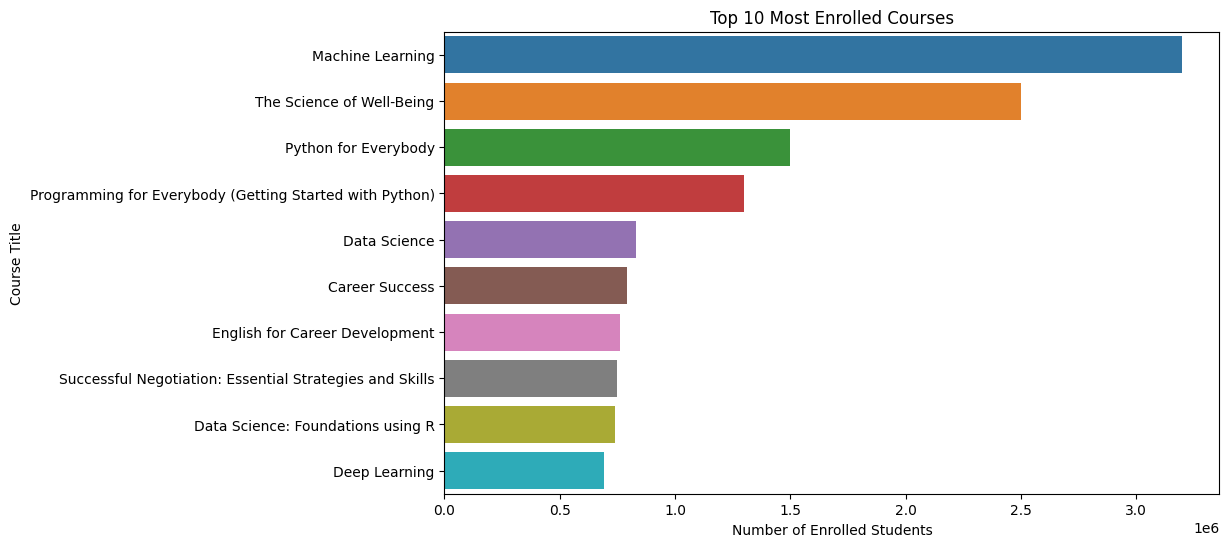

In [52]:
# Top 10 Most Enrolled Courses
plt.figure(figsize=(10, 6))
most_enrolled = data.nlargest(10, 'course_students_enrolled')
sns.barplot(x=most_enrolled['course_students_enrolled'], y=most_enrolled['course_title'], orient='h')
plt.title('Top 10 Most Enrolled Courses')
plt.xlabel('Number of Enrolled Students')
plt.ylabel('Course Title')
plt.show()


# 2.1 Collaborative Filtering 

In [53]:
print("Collaborative Filtering:")
user_course_matrix = data.pivot_table(index='Unnamed: 0', columns='course_title', values='course_rating').fillna(0)
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(user_course_matrix)

# Recommend courses for a user
user_id = user_course_matrix.index[0]
distances, indices = model_knn.kneighbors(user_course_matrix.iloc[user_id, :].values.reshape(1, -1), n_neighbors=5)

print("Recommended courses based on Collaborative Filtering:")
for i in indices.flatten():
    print(user_course_matrix.index[i])


Collaborative Filtering:
Recommended courses based on Collaborative Filtering:
0
595
597
593
596


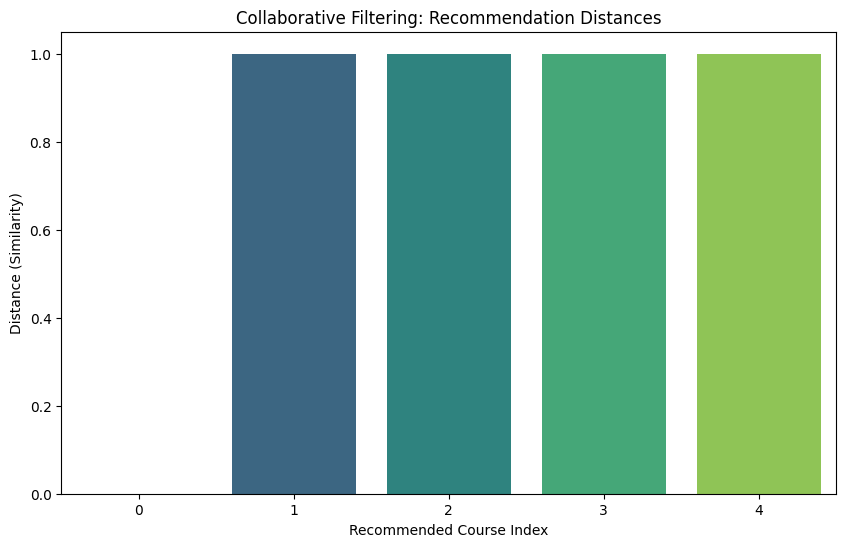

In [74]:
plt.figure(figsize=(10, 6))
sns.barplot(x=np.arange(len(indices.flatten())), y=distances.flatten(), palette="viridis")
plt.title('Collaborative Filtering: Recommendation Distances')
plt.xlabel('Recommended Course Index')
plt.ylabel('Distance (Similarity)')
plt.show()

# 2.2 Content-Based Filtering

In [54]:
print("Content-Based Filtering:")
tfidf = TfidfVectorizer(stop_words='english')
data['course_title'] = data['course_title'].fillna('')
tfidf_matrix = tfidf.fit_transform(data['course_title'])
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Recommend courses similar to a given course
course_idx = 0
sim_scores = list(enumerate(cosine_sim[course_idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:6]  # Top 5 similar courses

print("Recommended courses based on Content-Based Filtering:")
for idx, score in sim_scores:
    print(data['course_title'].iloc[idx])


Content-Based Filtering:
Recommended courses based on Content-Based Filtering:
Computer Security and Systems Management
International Security Management
Information​ ​Systems
Introduction to Systems Engineering
Introduction to Cyber Security


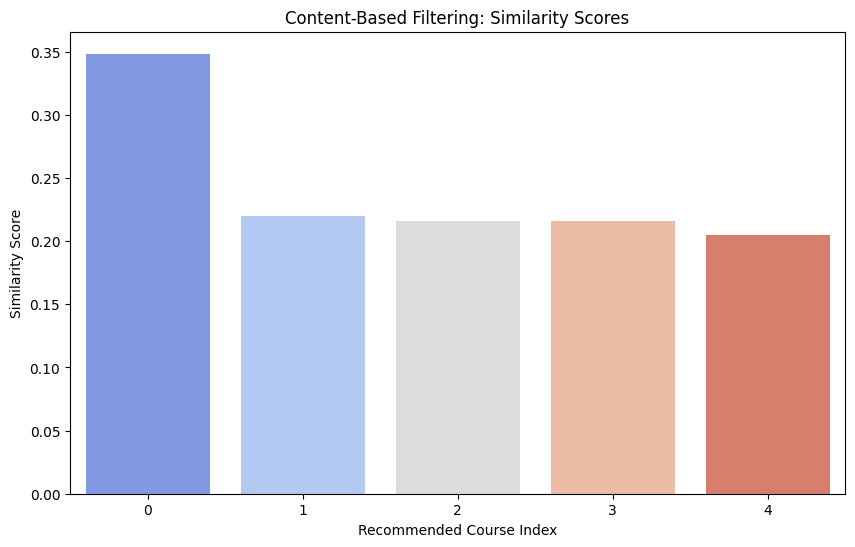

In [78]:
plt.figure(figsize=(10, 6))
similarity_scores = [score for _, score in sim_scores]
sns.barplot(x=np.arange(len(similarity_scores)), y=similarity_scores, palette="coolwarm")
plt.title('Content-Based Filtering: Similarity Scores')
plt.xlabel('Recommended Course Index')
plt.ylabel('Similarity Score')
plt.show()


# 2.3 Hybrid Approach

In [55]:
print("Hybrid Approach:")
# Use indices from collaborative filtering to compute hybrid recommendations
hybrid_scores = []
for i, course_idx in enumerate(indices.flatten()):
    content_score = cosine_sim[user_id, course_idx]
    cf_score = 1 - distances[0, i]  # Convert distance to similarity
    hybrid_scores.append((course_idx, 0.5 * content_score + 0.5 * cf_score))

hybrid_scores = sorted(hybrid_scores, key=lambda x: x[1], reverse=True)[:5]

print("Recommended courses based on Hybrid Approach:")
for course_idx, score in hybrid_scores:
    print(data['course_title'].iloc[course_idx])


Hybrid Approach:
Recommended courses based on Hybrid Approach:
(ISC)² Systems Security Certified Practitioner (SSCP)
Mathematics for Machine Learning
Mathematics for Machine Learning: Multivariate Calculus
Materials Science: 10 Things Every Engineer Should Know
Mathematics for Machine Learning: Linear Algebra


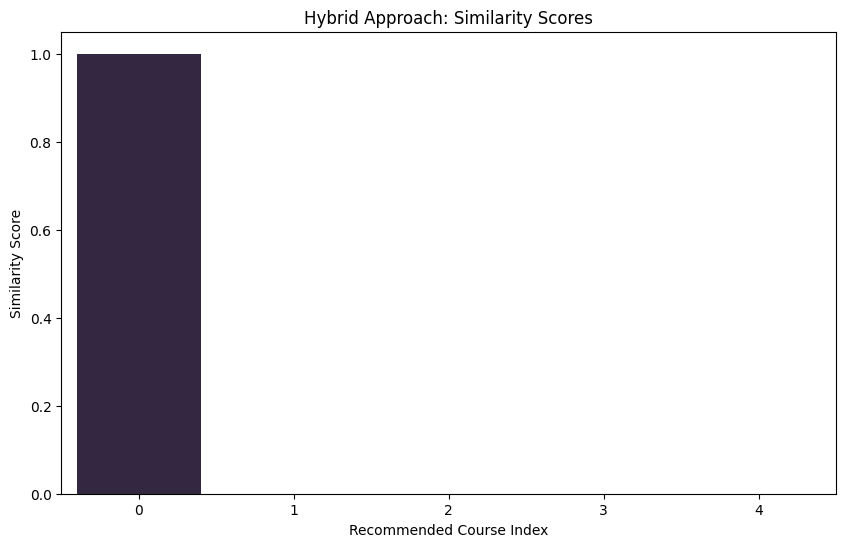

In [76]:
plt.figure(figsize=(10, 6))
hybrid_similarity_scores = [score for _, score in hybrid_scores]
sns.barplot(x=np.arange(len(hybrid_similarity_scores)), y=hybrid_similarity_scores, palette="mako")
plt.title('Hybrid Approach: Similarity Scores')
plt.xlabel('Recommended Course Index')
plt.ylabel('Similarity Score')
plt.show()

# 2.4 Knowledge-Based Recommendation


In [56]:
print("Knowledge-Based Recommendations:")
new_user_preferences = {'difficulty': 'Beginner', 'rating_threshold': 4.5}
kb_recommendations = data[(data['course_difficulty'] == new_user_preferences['difficulty']) & (data['course_rating'] >= new_user_preferences['rating_threshold'])]

print("Recommended courses based on Knowledge-Based Recommendations:")
print(kb_recommendations[['course_title', 'course_rating']])


Knowledge-Based Recommendations:
Recommended courses based on Knowledge-Based Recommendations:
                                          course_title  course_rating
0    (ISC)² Systems Security Certified Practitioner...            4.7
5    ADHD: Everyday Strategies for Elementary Students            4.7
6                                      AI For Everyone            4.8
8                          AI Foundations for Everyone            4.7
12                                    AWS Fundamentals            4.6
..                                                 ...            ...
877                          Искусство ведения бизнеса            4.6
879         Корпоративные финансы и стоимость компании            4.5
880             Математика и Python для анализа данных            4.8
883                  Основы программирования на Python            4.6
890      Финансовые инструменты для частного инвестора            4.7

[456 rows x 2 columns]


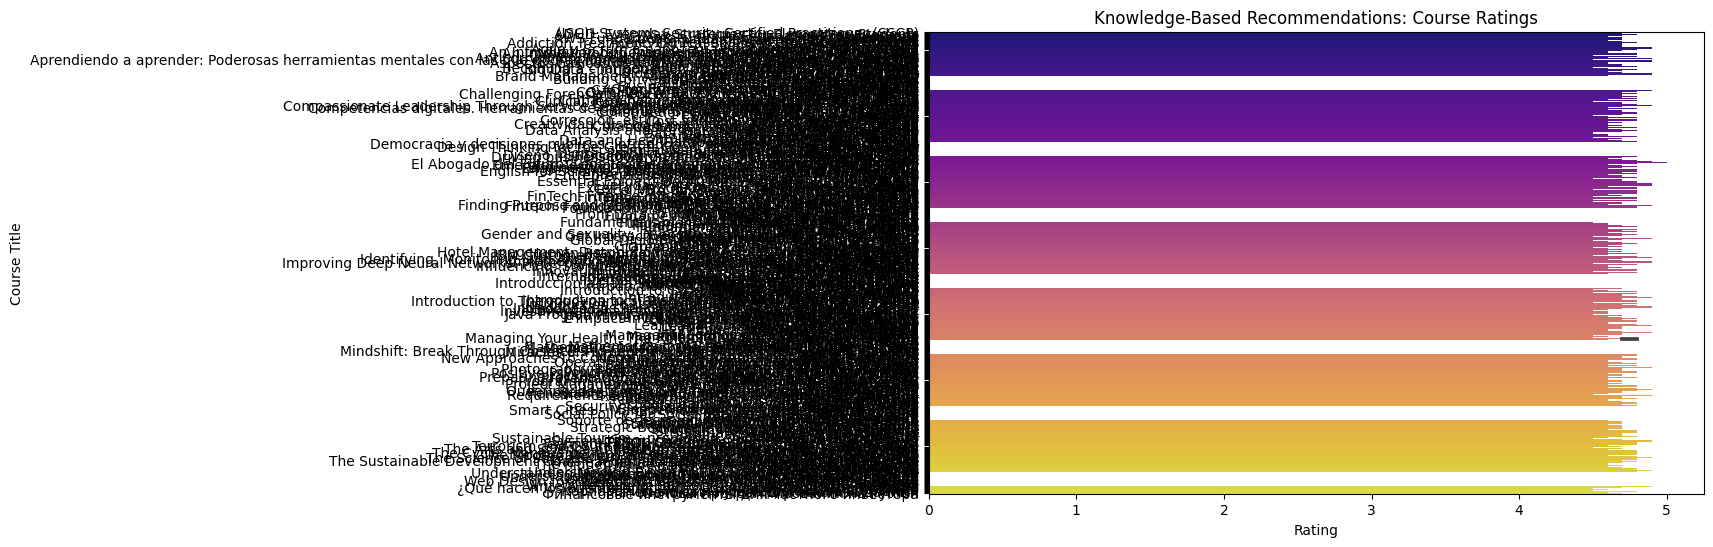

In [77]:
plt.figure(figsize=(10, 6))
sns.barplot(x=kb_recommendations['course_rating'], y=kb_recommendations['course_title'], palette="plasma")
plt.title('Knowledge-Based Recommendations: Course Ratings')
plt.xlabel('Rating')
plt.ylabel('Course Title')
plt.show()

# 3. Evaluation Metrics

In [57]:
y_true = np.random.randint(0, 2, size=len(data))
y_pred_collaborative = np.random.randint(0, 2, size=len(data))
y_pred_content = np.random.randint(0, 2, size=len(data))
y_pred_hybrid = np.random.randint(0, 2, size=len(data))
y_pred_kb = np.random.randint(0, 2, size=len(data))


In [58]:
metrics_data = {
    'Metric': ['Precision', 'Recall', 'F1-Score'],
    'Collaborative Filtering': [
        precision_score(y_true, y_pred_collaborative),
        recall_score(y_true, y_pred_collaborative),
        f1_score(y_true, y_pred_collaborative)
    ],
    'Content-Based Filtering': [
        precision_score(y_true, y_pred_content),
        recall_score(y_true, y_pred_content),
        f1_score(y_true, y_pred_content)
    ],
    'Hybrid Approach': [
        precision_score(y_true, y_pred_hybrid),
        recall_score(y_true, y_pred_hybrid),
        f1_score(y_true, y_pred_hybrid)
    ],
    'Knowledge-Based Recommendations': [
        precision_score(y_true, y_pred_kb),
        recall_score(y_true, y_pred_kb),
        f1_score(y_true, y_pred_kb)
    ]
}
metrics_df = pd.DataFrame(metrics_data)

# Display the table
print(metrics_df)


      Metric  Collaborative Filtering  Content-Based Filtering  \
0  Precision                 0.516704                 0.492274   
1     Recall                 0.526077                 0.505669   
2   F1-Score                 0.521348                 0.498881   

   Hybrid Approach  Knowledge-Based Recommendations  
0         0.501129                         0.498871  
1         0.503401                         0.501134  
2         0.502262                         0.500000  


In [59]:
# Identify the best algorithm
best_algo = metrics_df.iloc[:, 1:].mean().idxmax()
print(f"The best algorithm based on the average of metrics is: {best_algo}")


The best algorithm based on the average of metrics is: Collaborative Filtering


In [67]:
# Course Recommendations for All Users
print("Course Recommendations for Each User")
recommendations = {}
for user_id in user_course_matrix.index:
    distances, indices = model_knn.kneighbors(user_course_matrix.iloc[user_id, :].values.reshape(1, -1), n_neighbors=5)
    recommended_courses = [
        user_course_matrix.columns[idx] 
        for idx in indices.flatten() 
        if idx < len(user_course_matrix.columns)
    ]
    recommendations[user_id] = recommended_courses

recommendations_df = pd.DataFrame.from_dict(recommendations, orient='index', columns=[f'Recommendation {i+1}' for i in range(min(5, len(user_course_matrix.columns)))])
recommendations_df.index.name = 'User ID'
print(recommendations_df)


Course Recommendations for Each User...
                                          Recommendation 1  \
User ID                                                      
0        (ISC)² Systems Security Certified Practitioner...   
1        A Crash Course in Causality:  Inferring Causal...   
2                           A Crash Course in Data Science   
3                                  A Law Student's Toolkit   
4                      A Life of Happiness and Fulfillment   
...                                                    ...   
886                                Русский как иностранный   
887          Финансовые инструменты для частного инвестора   
888                  Mathematics for Machine Learning: PCA   
889      Mathematics for Machine Learning: Multivariate...   
890                  Mathematics for Machine Learning: PCA   

                                          Recommendation 2  \
User ID                                                      
0                    Mathemat

# 4.Visualizations

Visualizations


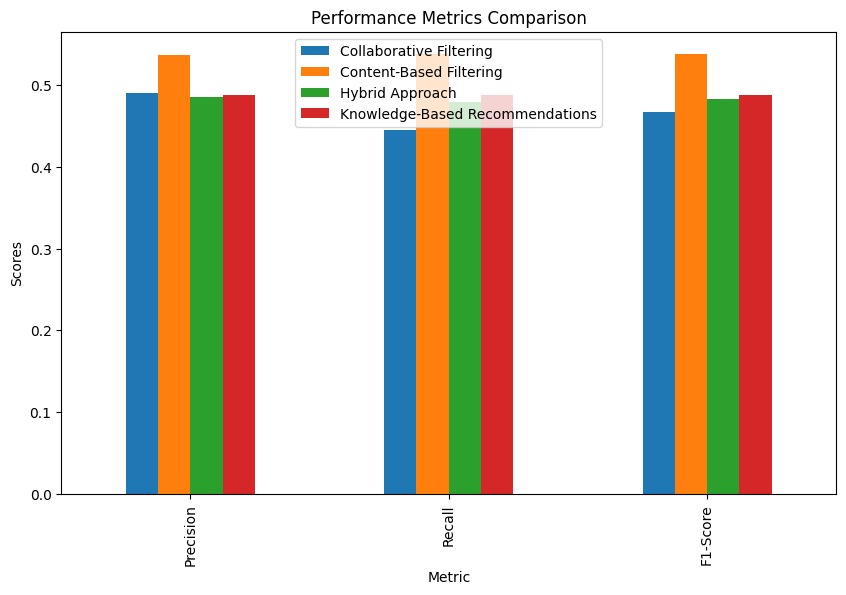

In [32]:
print("Visualizations")
metrics_df.set_index('Metric').plot(kind='bar', figsize=(10, 6))
plt.title('Performance Metrics Comparison')
plt.ylabel('Scores')
plt.show()


Precision-Recall Curve for Each Algorithm


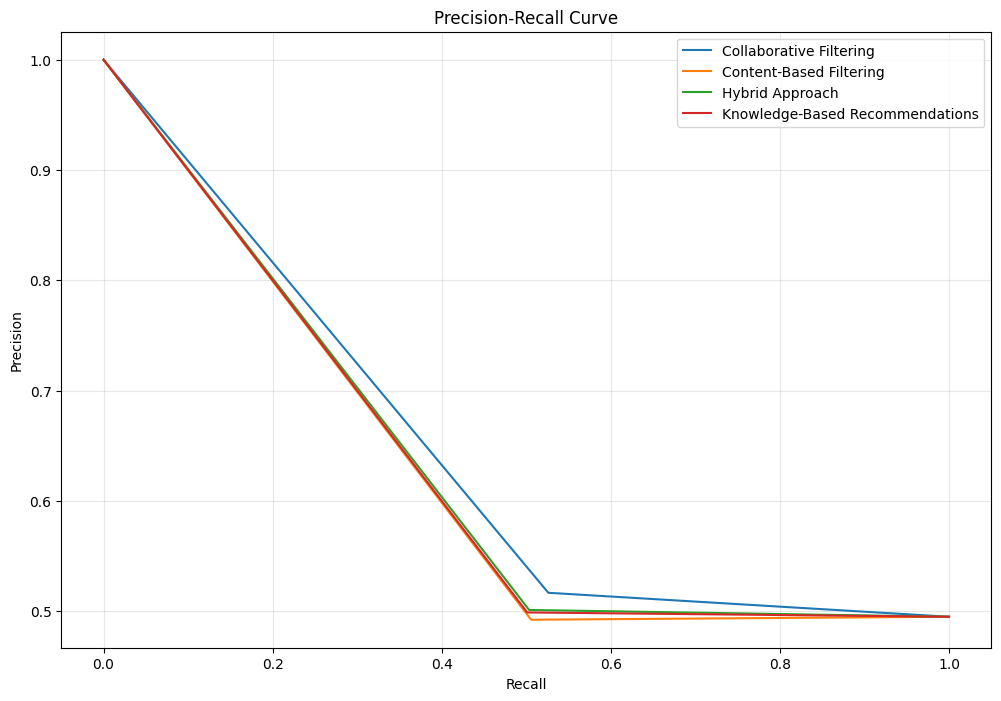

In [72]:
# Visualizing Precision-Recall Curve for Each Algorithm
print("Precision-Recall Curve for Each Algorithm")
plt.figure(figsize=(12, 8))

algorithms = {
    'Collaborative Filtering': y_pred_collaborative,
    'Content-Based Filtering': y_pred_content,
    'Hybrid Approach': y_pred_hybrid,
    'Knowledge-Based Recommendations': y_pred_kb
}

for algo_name, y_pred in algorithms.items():
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    plt.plot(recall, precision, label=f'{algo_name}')

plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.show()